# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt

import sys
import time

from collections import Counter

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
epochs = 100
num_neurons = 128
onehot_dims = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [4]:
all_data = pd.read_csv("./data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0


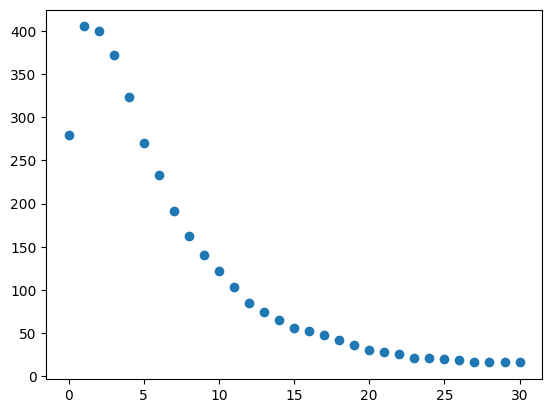

In [5]:
counter = Counter(all_data['steps_num_lo'])
counter = dict(counter)

plt.scatter(counter.keys(), counter.values())

In [6]:
bin_edges = [1, 3, 6, 10, 15, 25]

In [7]:
# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["simple_terms"].tolist(), all_data["steps_num_lo"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count training samples: 2952
Count testing samples: 739


In [8]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 7))

y_train = np.digitize(y_train, bin_edges)
y_test = np.digitize(y_test, bin_edges)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [9]:
xy_train_data = list(zip(x_train, y_train))
xy_test_data = list(zip(x_test, y_test))

In [10]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 739
len(train_data) = 2952


In [11]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), np.array([ytd])


def val_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), np.array([ytd])

# Define the model

In [12]:
model = Sequential()
model.add(LSTM(units=num_neurons,
               input_shape=(None, onehot_dims)))
model.add(Dense(units=7, activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 68999 (269.53 KB)
Trainable params: 68999 (269.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model_structure = model.to_json()
with open("./fine_models/v1.2_lstm_bin_steps_pred.json", 'w') as json_file:
    json_file.write(model_structure)

In [15]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v1.2_lstm_bin_steps_pred.h5',  # Specify the path to save the best model
    monitor='accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [16]:
history = model.fit(train_generator(), steps_per_epoch=2952, validation_data=val_generator(), validation_steps=739, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/100
2952/2952 [==============================] - 86s 28ms/step - loss: 1.8049 - accuracy: 0.2510 - val_loss: 1.8656 - val_accuracy: 0.2206
Epoch 2/100
   4/2952 [..............................] - ETA: 56s - loss: 1.9449 - accuracy: 0.2500     

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 81s 28ms/step - loss: 1.7960 - accuracy: 0.2483 - val_loss: 1.8389 - val_accuracy: 0.2503
Epoch 3/100
2952/2952 [==============================] - 82s 28ms/step - loss: 1.7904 - accuracy: 0.2564 - val_loss: 1.7767 - val_accuracy: 0.2476
Epoch 4/100
2952/2952 [==============================] - 79s 27ms/step - loss: 1.7644 - accuracy: 0.2724 - val_loss: 1.6971 - val_accuracy: 0.2991
Epoch 5/100
2952/2952 [==============================] - 81s 27ms/step - loss: 1.5599 - accuracy: 0.3188 - val_loss: 1.4772 - val_accuracy: 0.3843
Epoch 6/100
2952/2952 [==============================] - 84s 28ms/step - loss: 1.4795 - accuracy: 0.3442 - val_loss: 1.5607 - val_accuracy: 0.2828
Epoch 7/100
2952/2952 [==============================] - 82s 28ms/step - loss: 1.4385 - accuracy: 0.3601 - val_loss: 1.4501 - val_accuracy: 0.3505
Epoch 8/100
2952/2952 [==============================] - 83s 28ms/step - loss: 1.3909 - accuracy: 0.3797 - val_loss: 1.3705 - val_

In [13]:
# annoing when pycharm broke

loss_arr = [1.8049, 1.7960, 1.7904, 1.7644, 1.5599, 1.4795, 1.4385, 1.3909, 1.3080, 1.1887, 1.1139, 1.0843, 1.0618, 1.0328, 0.9997, 0.9716, 0.9418, 0.9215, 0.8883, 0.8812, 0.8551, 0.8127, 0.7937, 0.7620, 0.7382, 0.7123, 0.6970, 0.7092, 0.6717, 0.6107, 0.6023, 0.5750, 0.6352, 0.5442, 0.5559, 0.5618, 0.5334, 0.4878, 0.4977, 0.4775, 0.4330, 0.4500, 0.4309, 0.4183, 0.3898, 0.5056, 0.4095, 0.3906, 0.3899, 0.3828, 0.3648, 0.4094, 0.2919, 0.3242, 0.3648, 0.3456, 0.3693, 0.3084, 0.3514, 0.3260, 0.3103, 0.3763, 0.3019, 0.3053, 0.2932, 0.2994, 0.2420, 0.2559, 0.2791, 0.2502, 0.2788, 0.2367, 0.2406, 0.2577, 0.2252, 0.2247, 0.2512, 0.2041, 0.1986, 0.2178, 0.2232, 0.1919, 0.2170, 0.1835, 0.1817, 0.2114, 0.2001, 0.2016, 0.2044, 0.1860, 0.1802, 0.1853, 0.1735, 0.1695, 0.1683, 0.1822, 0.1601, 0.1926, 0.1599, 0.1568, ]
accuracy_arr = [0.2510, 0.2483, 0.2564, 0.2724, 0.3188, 0.3442, 0.3601, 0.3797, 0.4295, 0.4763, 0.5034, 0.5139, 0.5451, 0.5437, 0.5593, 0.5545, 0.5749, 0.5898, 0.6009, 0.6121, 0.6206, 0.6453, 0.6494, 0.6592, 0.6778, 0.6948, 0.6958, 0.6839, 0.7100, 0.7354, 0.7449, 0.7585, 0.7300, 0.7717, 0.7646, 0.7595, 0.7778, 0.7988, 0.7978, 0.8056, 0.8242, 0.8093, 0.8218, 0.8249, 0.8438, 0.8062, 0.8269, 0.8499, 0.8489, 0.8469, 0.8533, 0.8337, 0.8896, 0.8703, 0.8577, 0.8675, 0.8520, 0.8764, 0.8631, 0.8753, 0.8804, 0.8577, 0.8811, 0.8825, 0.8814, 0.8831, 0.9051, 0.8991, 0.8963, 0.9082, 0.8892, 0.9126, 0.9136, 0.9041, 0.9112, 0.9129, 0.9072, 0.9248, 0.9248, 0.9197, 0.9102, 0.9333, 0.9211, 0.9329, 0.9326, 0.9258, 0.9289, 0.9214, 0.9241, 0.9333, 0.9312, 0.9353, 0.9377, 0.9356, 0.9394, 0.9350, 0.9404, 0.9353, 0.9465, 0.9475, ]

val_loss_arr = [1.8656, 1.8389, 1.7767, 1.6971, 1.4772, 1.5607, 1.4501, 1.3705, 1.2514, 1.2006, 1.1604, 1.0516, 1.0785, 1.1187, 1.0307, 1.0394, 1.0003, 0.9946, 1.0029, 0.9690, 0.9595, 0.9588, 0.9243, 0.9816, 0.9035, 0.9625, 0.9100, 0.9568, 0.9139, 0.9769, 0.9928, 0.9129, 0.9746, 1.0155, 0.9335, 1.0149, 1.0017, 1.0500, 1.0248, 0.9815, 1.0736, 1.0414, 1.1288, 1.0477, 1.1837, 1.1007, 1.0968, 1.0865, 1.2311, 1.1358, 1.1958, 1.1199, 1.2008, 1.1531, 1.1385, 1.1723, 1.0454, 1.1752, 1.1169, 1.1828, 1.2437, 1.0678, 1.2669, 1.1366, 1.1779, 1.1786, 1.2847, 1.2952, 1.2312, 1.2364, 1.2724, 1.2717, 1.3857, 1.3993, 1.4692, 1.2952, 1.2430, 1.3960, 1.3839, 1.2771, 1.2990, 1.5251, 1.3523, 1.3360, 1.3951, 1.3985, 1.3705, 1.3185, 1.4215, 1.4007, 1.3575, 1.4186, 1.4382, 1.5299, 1.4085, 1.4236, 1.4710, 1.4045, 1.4796, 1.4682,]
val_acc_arr = [0.2206, 0.2503, 0.2476, 0.2991, 0.3843, 0.2828, 0.3505, 0.3924, 0.4601, 0.4885, 0.4723, 0.5413, 0.5264, 0.5183, 0.5318, 0.5426, 0.5521, 0.5589, 0.5602, 0.5629, 0.5683, 0.5643, 0.6008, 0.5656, 0.5900, 0.5724, 0.6130, 0.5521, 0.6022, 0.5954, 0.5873, 0.6401, 0.5954, 0.6008, 0.6116, 0.6116, 0.6211, 0.6292, 0.6171, 0.6211, 0.6157, 0.6265, 0.6022, 0.6238, 0.6157, 0.6292, 0.6184, 0.6401, 0.6062, 0.6211, 0.6211, 0.6401, 0.6360, 0.6198, 0.6414, 0.6306, 0.6536, 0.6604, 0.6184, 0.6387, 0.6143, 0.6373, 0.6265, 0.6414, 0.6360, 0.6373, 0.6373, 0.6360, 0.6522, 0.6373, 0.6495, 0.6522, 0.6225, 0.6130, 0.6292, 0.6455, 0.6509, 0.6373, 0.6414, 0.6658, 0.6631, 0.6387, 0.6522, 0.6536, 0.6590, 0.6455, 0.6414, 0.6617, 0.6495, 0.6604, 0.6495, 0.6428, 0.6482, 0.6536, 0.6549, 0.6373, 0.6563, 0.6576, 0.6563, 0.6712, ]

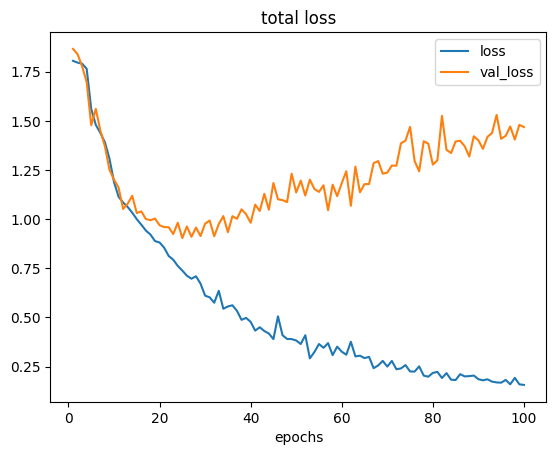

In [14]:
plt.plot(range(1, epochs + 1), loss_arr, label="loss")
plt.plot(range(1, epochs + 1), val_loss_arr, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

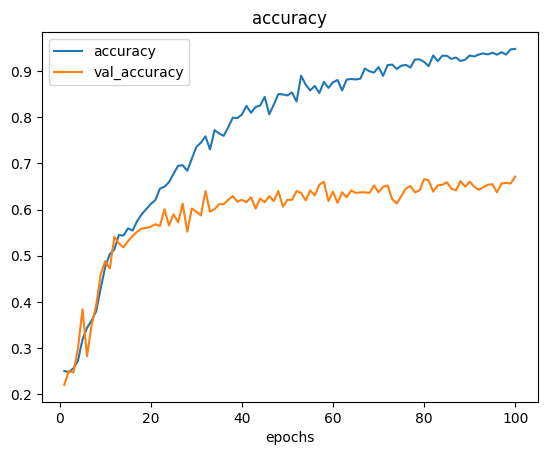

In [15]:
plt.plot(range(1, epochs + 1), accuracy_arr, label="accuracy")
plt.plot(range(1, epochs + 1), val_acc_arr, label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [16]:
# load the model
with open("./fine_models/v1.2_lstm_bin_steps_pred.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("./fine_models/v1.2_lstm_bin_steps_pred.h5")

In [17]:
y_test_pred = []
for x_ in x_test:
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])

In [18]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

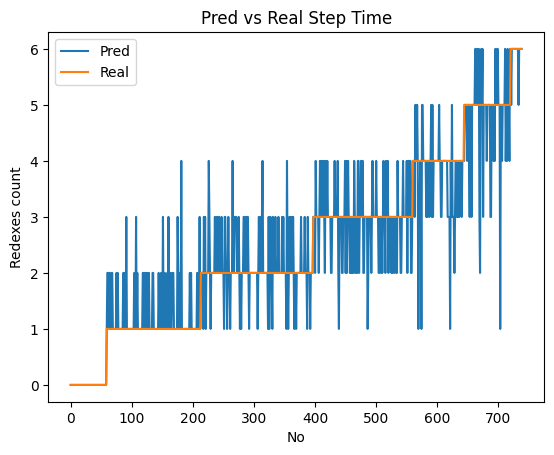

In [19]:
y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)

In [20]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

Test accuracy: 0.6711772665764547


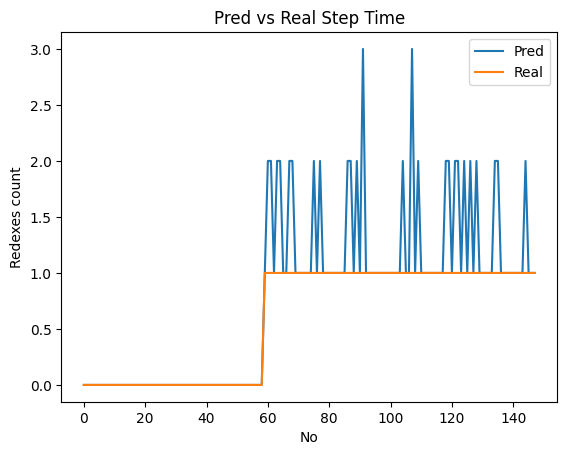

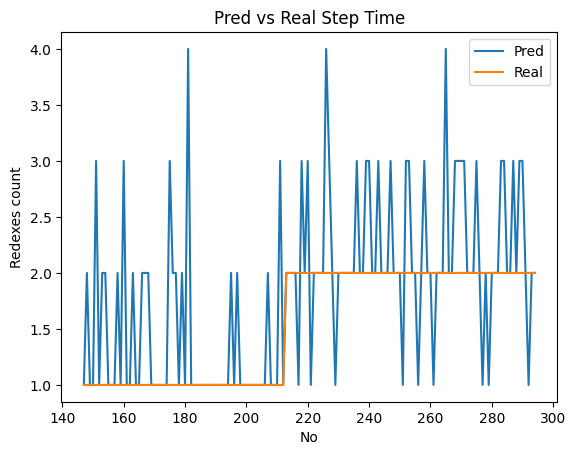

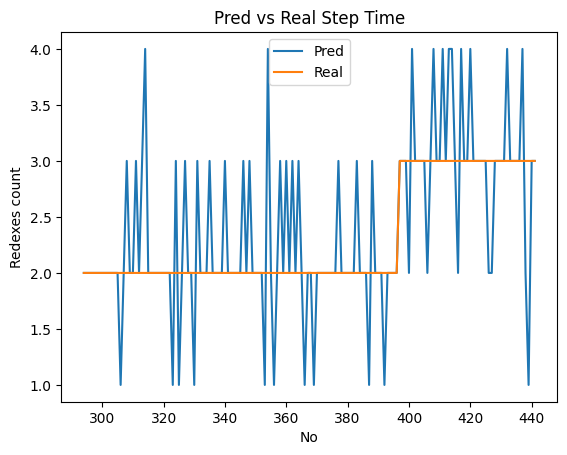

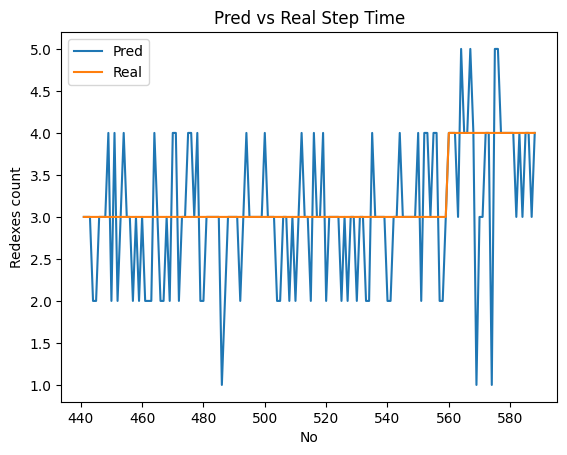

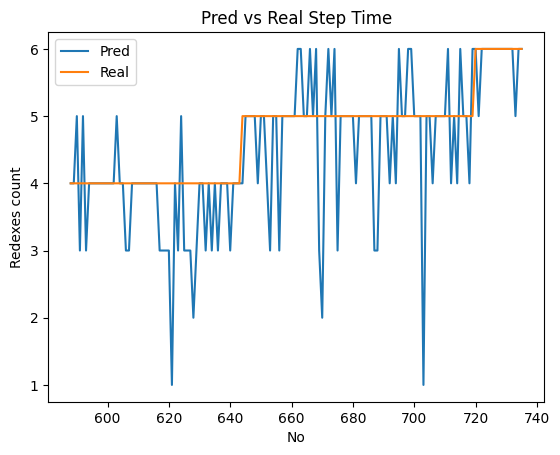

In [21]:
def draw_pred_lines_steps(y_pred, y_real, ranges):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    range_step = int(len(y_pred) / ranges)
    for range_no in range(ranges):
        for key_, val_ in drawing_df.items():
            plt.plot(range(range_no * range_step, ((range_no + 1) * range_step) + 1), val_[range_no * range_step : ((range_no + 1) * range_step) + 1], label=key_)

        plt.xlabel("No")
        plt.ylabel("Redexes count")
        plt.title("Pred vs Real Step Time")
        plt.legend()
        plt.show()


draw_pred_lines_steps(y_test_pred_nums, y_test_nums, 5)

Train accuracy: 0.9695121951219512


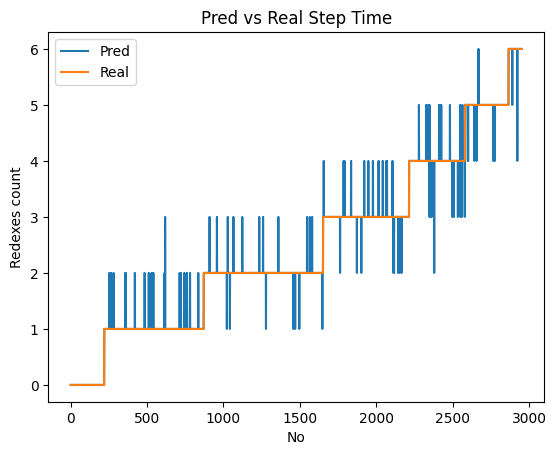

In [22]:
y_train_pred = []
for x_ in x_train:
    y_train_pred.append(model.predict(np.array([x_]), verbose=0)[0])

y_train_pred_nums = encoder.inverse_transform(np.array(y_train_pred))
y_train_nums = encoder.inverse_transform(y_train)

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))

draw_pred_lines(y_train_pred_nums, y_train_nums)

In [23]:
y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [24]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    prediction_ = model_.predict(tokenize_and_vectorize([term_.simple_str()]), verbose=0)
    print(f"{term_deskr_}\nnorm_steps={np.digitize(term_.normalize(LOStrategy())[1], bin_edges)}\tpred_steps={np.argmax(prediction_[0])}\n")


list_test_functions = (term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10, term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
norm_steps=1	pred_steps=2

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
norm_steps=2	pred_steps=2

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=2	pred_steps=2

(PRED 0) == 0 == λx. λy. y
norm_steps=2	pred_steps=1

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=5	pred_steps=1

(PLUS 0 0) == 0 == λx. λy. y
norm_steps=2	pred_steps=2

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
norm_steps=4	pred_steps=2

(SUBTRACT 3 5) == 0 == λx. λy. y
norm_steps=6	pred_steps=4

(LEQ 3 2) == FALSE == λx. λy. y
norm_steps=6	pred_steps=3

(LEQ 2 5) == TRUE == λx. λy. x
norm_steps=6	pred_steps=5

(EQ 2 2) == TRUE == λx. λy. x
norm_steps=6	pred_steps=3

(EQ 1 4) == FALSE == λx. λy. y
norm_steps=6	pred_steps=3

Omega(3, 3)  == I == λx. x
norm_steps=3	pred_steps=3

GCD_vO 5 2
norm_steps=6	pred_steps=3

GCD_v1 5 2
norm_steps=6	pred_steps=5

GCD_v3 5 2
norm_steps=6	pred_steps=3

PYTHAGOREAN 5 2 2
norm_steps=6	pred_steps=3



In [25]:
list_simplified_omega_terms = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        list_simplified_omega_terms.append(term_.simple_str())

list_simplified_omega_terms = tokenize_and_vectorize(list_simplified_omega_terms)

real_redexes_count = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        real_redexes_count.append(np.digitize(term_.normalize(LOStrategy())[1], bin_edges))

predictions_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    predictions_omega_terms_redexes.append(np.argmax(model.predict([rec_], verbose=0)[0]))

100%|██████████| 400/400 [00:45<00:00,  8.73it/s]


In [26]:
print(predictions_omega_terms_redexes)

[1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 

In [27]:
print(real_redexes_count)

[1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 1, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 2, 3, 3, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 3, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [28]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(real_redexes_count, predictions_omega_terms_redexes))

Test accuracy: 0.07


In [29]:
green_dots = []
red_dots = []

for n in range(0, 20):
    for m in range(0, 20):
        val = predictions_omega_terms_redexes[n * 20 + m]
        val_real = real_redexes_count[n * 20 + m]

        if val == val_real:
            green_dots.append((n+1, m+1))
        else:
            red_dots.append((n+1, m+1))


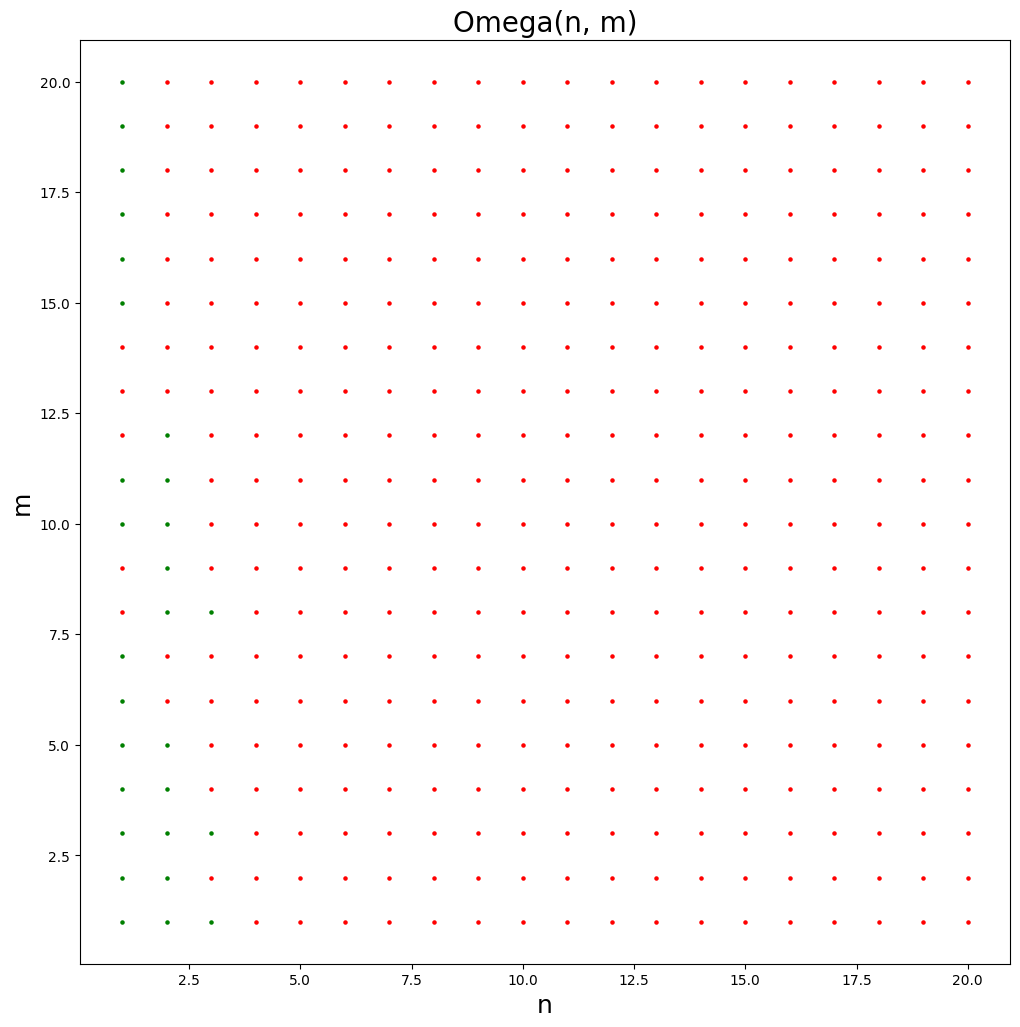

In [30]:
plt.figure(figsize=(12, 12))

green_dots = np.array(green_dots)
red_dots = np.array(red_dots)

plt.scatter(green_dots[:,0], green_dots[:,1], s=5, c='green',)
plt.scatter(red_dots[:,0], red_dots[:,1], s=5, c='red',)

plt.xlabel("n", fontsize=18)
plt.ylabel("m", fontsize=18)
plt.title("Omega(n, m)", fontsize=20)
plt.show()

# Aditional metrics avaluation

## Mean Squared Error

In [48]:
_, _, y_train_, y_test_ = train_test_split(all_data["simple_terms"].tolist(), all_data["steps_num_lo"].tolist(),
                                                    test_size=0.2, random_state=42)

In [56]:
mapper = pd.DataFrame({"y_train_steps": y_train_}).groupby(y_train_nums).mean().to_dict()
mapper = mapper["y_train_steps"]

In [57]:
mapper

{0: 0.0,
 1: 1.5007680491551458,
 2: 3.9078104993597953,
 3: 7.289520426287744,
 4: 11.620218579234972,
 5: 18.424561403508772,
 6: 27.372093023255815}

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

In [59]:
mse_train = mean_squared_error(y_train_, [mapper[y_] for y_ in y_train_pred_nums])
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(y_test_, [mapper[y_] for y_ in y_test_pred_nums])
print("Test {Mean Squared Error}:", mse_test)

Train {Mean Squared Error}: 1.9342824887827421
Test {Mean Squared Error}: 7.1408126019593325


## Mean Absolute Error

In [60]:
mae_train = mean_absolute_error(y_train_, [mapper[y_] for y_ in y_train_pred_nums])
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(y_test_, [mapper[y_] for y_ in y_test_pred_nums])
print("Test {Mean Absolute Error}:", mae_test)

Train {Mean Absolute Error}: 0.9653285082386183
Test {Mean Absolute Error}: 1.7670106381724613


## Mean Absolute Percentage Error

In [63]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train_, np.array([mapper[y_] for y_ in y_train_pred_nums]))
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(y_test_, np.array([mapper[y_] for y_ in y_test_pred_nums]))
print("Test {Mean Absolute Percentage Error}:", mape_test)

Train {Mean Absolute Percentage Error}: 19.795468882604464
Test {Mean Absolute Percentage Error}: 38.16902660756209


## Percentage of Explained Variance (PEV)

In [64]:
# Calculate Variance of the target variable
variance_y_test = np.var(y_test_)
variance_y_train = np.var(y_train_)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Test {Percentage of Explained Variance}:", pev_test)

Train {Percentage of Explained Variance}: 95.35679975775659
Test {Percentage of Explained Variance}: 83.24234749251214


## Mean Bias Deviation

In [65]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(y_train_, np.array([mapper[y_] for y_ in y_train_pred_nums]))
print("Train {Mean Bias Deviation}:", mbd_train)

mdb_test = mean_bias_deviation(y_test_, np.array([mapper[y_] for y_ in y_test_pred_nums]))
print("Test {Mean Bias Deviation}:", mdb_test)

Train {Mean Bias Deviation}: 5.842740348666389
Test {Mean Bias Deviation}: 17.65424964320577


## Coefficient of Correlation (Pearson's r)

In [66]:
coc_test = np.corrcoef([mapper[y_] for y_ in y_test_pred_nums], y_test_)[0, 1]
coc_train = np.corrcoef([mapper[y_] for y_ in y_train_pred_nums], y_train_)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Test {Mean Bias Deviation}:", coc_test)

Train {Mean Bias Deviation}: 0.9765350082761556
Test {Mean Bias Deviation}: 0.914726979273729
